# Unsupervised surgery pipeline with TRVAE

In [1]:
import os
import timeit
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [4]:
condition_key = 'batch'
target_conditions = ["10X"]


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC
To: c:\Helmholtz\scarches\notebooks\pbmc.h5ad
100%|██████████| 2.06G/2.06G [03:27<00:00, 9.97MB/s]


'pbmc.h5ad'

In [6]:
adata = sc.read('pbmc.h5ad')

In [7]:
adata.X = adata.layers["counts"].copy()

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [8]:
# adata = adata.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata.raw = source_adata
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [9]:
source_adata

AnnData object with n_obs × n_vars = 22779 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [10]:
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [11]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [12]:
trvae.train(
    n_epochs=10,
    alpha_epoch_anneal=1,
    early_stopping_kwargs=early_stopping_kwargs
)

 |████████████████████| 100.0%  - val_loss: 5154.5556911892 - val_recon_loss: 5089.8730197483 - val_kl_loss: 15.1531530486 - val_mmd_loss: 49.5295107100
Saving best state of network...
Best State was in Epoch 9


### Create anndata file of latent representation and compute UMAP

In [13]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['tissue'] = source_adata.obs["tissue"].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

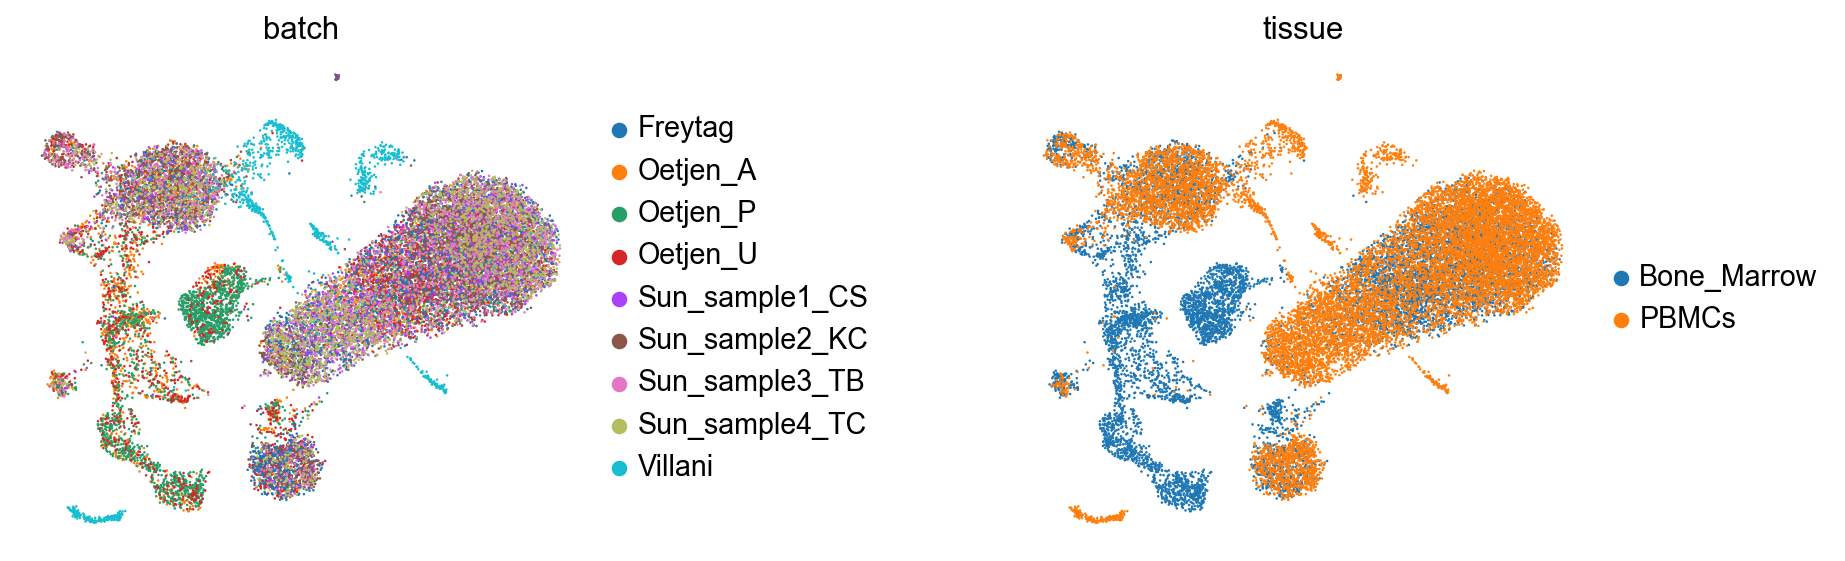

In [14]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'tissue'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [15]:
ref_path = 'reference_model/'
# trvae.save(ref_path, overwrite=True)

### Perform surgery on reference model and train on query dataset

One-shot function execution + timing

In [16]:
start_time = timeit.default_timer()
query_model = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 1)
print(f'Executed in {timeit.default_timer() - start_time} seconds') 

AttributeError: 'TRVAE' object has no attribute 'one_shot_surgery'

In [ ]:
adata_latent = sc.AnnData(query_model.get_latent())
adata_latent.obs['tissue'] = target_adata.obs['tissue'].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [ ]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'tissue'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
surg_path = 'surgery_model'
query_model.save(surg_path, overwrite=True)

### UP TO HERE

### Get latent representation of reference + query dataset and compute UMAP

In [ ]:
full_latent = sc.AnnData(query_model.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['tissue'] = adata.obs['tissue'].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()

In [ ]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'tissue'],
           frameon=False,
           wspace=0.6,
           )